# Tutorial 1：Simulated multi-omics data Integration

We evaluated the performance of SMART using simulated spatial multi-omics data with known ground truth. The ground truth of the simulated data defines five distinct spatial factors: factors 1 through 4, representing different cell types, and a background category. The simulation includes three distinct modalities, RNA, ADT,and ATAC, which exhibit markedly different expression distributions, reflecting the complementary nature of multi-omics data.

The raw data can be downloaded from: https://drive.google.com/drive/folders/1pIK6hZCvqHNh0K94-Lgy-CTyfixEUftQ?usp=drive_link.

## Load packages

In [ ]:
import os
import torch
import pandas as pd
import scanpy as sc
import warnings
from muon import prot as pt
from muon import atac as ac
from smart.train import train_SMART
from smart.utils import set_seed
from smart.utils import pca
from smart.utils import Cal_Spatial_Net
from smart.utils import Mutual_Nearest_Neighbors
from smart.utils import clustering
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

set_seed(2024)

warnings.filterwarnings('ignore')
# Environment configuration. SMART pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path, use the command `R RHOME` to find the path.
os.environ['R_HOME'] = '/public/home/cit_wlhuang/.conda/envs/smart/lib/R'

/public/home/cit_wlhuang/.conda/envs/smart-copy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
# read data
file_fold = '../SMART-main_orignal/datasets/simulated_data/'  #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics3 = sc.read_h5ad(file_fold + 'adata_ATAC.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics3.var_names_make_unique()

adata_omics1.obs["anno"]=pd.read_table(file_fold+"anno.txt",header=None).loc[adata_omics1.obs.index.astype("int")].values[:, 0].astype("str")

adata_omics1,adata_omics2,adata_omics3

(AnnData object with n_obs × n_vars = 1296 × 1000
     obs: 'anno'
     uns: 'log1p'
     obsm: 'nsfac', 'spatial', 'spfac'
     varm: 'nsload', 'spload'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 1296 × 100
     uns: 'log1p'
     obsm: 'nsfac', 'spatial', 'spfac'
     varm: 'nsload', 'spload'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 1296 × 1000
     uns: 'log1p'
     obsm: 'nsfac', 'spatial', 'spfac'
     varm: 'nsload', 'spload'
     layers: 'counts')

## Data pre-processing

In [ ]:
# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=30)

# Protein
adata_omics2 = adata_omics2[adata_omics1.obs_names].copy() 
pt.pp.clr(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=30)

# ATAC
adata_omics3 = adata_omics3[adata_omics1.obs_names].copy()  # .obsm['X_lsi'] represents the dimension reduced feature
ac.pp.tfidf(adata_omics3, scale_factor=1e4)
sc.pp.normalize_per_cell(adata_omics3, counts_per_cell_after=1e4)
sc.pp.log1p(adata_omics3)
adata_omics3.obsm['feat'] = pca(adata_omics3, n_comps=30)

## Spatial neighbour graph construction

In [ ]:
Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=4)
Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=4)
Cal_Spatial_Net(adata_omics3, model="KNN", n_neighbors=4)

The graph contains 5184 edges, 1296 cells.
4.0000 neighbors per cell on average.
The graph contains 5184 edges, 1296 cells.
4.0000 neighbors per cell on average.
The graph contains 5184 edges, 1296 cells.
4.0000 neighbors per cell on average.


## MNN triplet samples calculation

In [ ]:
adata_list=[adata_omics1,adata_omics2,adata_omics3]
x = [torch.FloatTensor(adata.obsm["feat"]).to(device) for adata in adata_list]
edges =[torch.LongTensor(adata.uns["edgeList"]).to(device) for adata in adata_list]
triplet_samples_list = [Mutual_Nearest_Neighbors(adata, key="feat", n_nearest_neighbors=3,farthest_ratio=0.6) for adata in adata_list]

Distances calculation completed!
The data using feature 'feat' contains 1846 mnn_anchors
Distances calculation completed!
The data using feature 'feat' contains 1742 mnn_anchors
Distances calculation completed!
The data using feature 'feat' contains 1732 mnn_anchors


## Model training

In [ ]:
model=train_SMART(features=x,
            edges=edges,
            triplet_samples_list=triplet_samples_list,
            weights=[1,1,1,1,1,1],
            emb_dim=64, 
            n_epochs=300,
            lr=1e-3,
            weight_decay=1e-6,
            device = device,
            window_size=10,
            slope=1e-4)

adata_omics1.obsm["SMART"]=model(x, edges)[0].cpu().detach().numpy()

 30%|██▉       | 89/300 [00:04<00:10, 20.05it/s]

Stopping for flat trend


## Clustering

In [ ]:
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_omics1, key='SMART', add_key='SMART', n_clusters=5, method=tool, use_pca=True)
ari = adjusted_rand_score(adata_omics1.obs['anno'], adata_omics1.obs['SMART'])
print(ari)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
0.9915746740083633


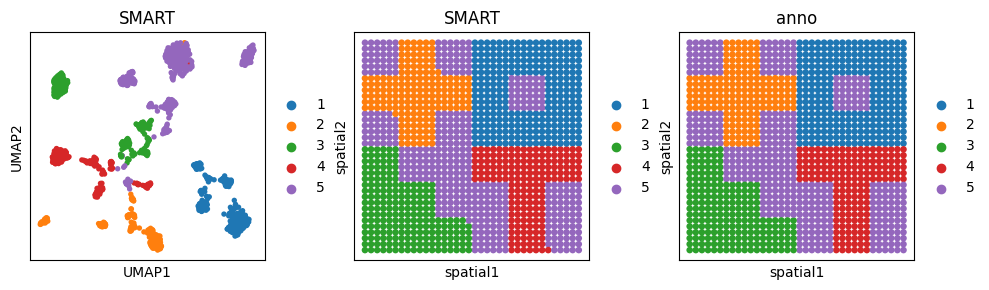

In [ ]:
fig, ax_list = plt.subplots(1, 3, figsize=(10, 3))
sc.pp.neighbors(adata_omics1, use_rep='SMART', n_neighbors=10)
sc.tl.umap(adata_omics1)
sc.pl.umap(adata_omics1, color='SMART', ax=ax_list[0], title='SMART', s=60, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='SMART', ax=ax_list[1], title='SMART', s=90, show=False)
sc.pl.embedding(adata_omics1, basis='spatial', color='anno', ax=ax_list[2], title='anno', s=90, show=False)
plt.tight_layout(w_pad=0.3)
plt.show()